# 1. Import Libraries

In [1]:
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)

In [2]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import plotly.express as px
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD, Adam,  RMSprop, Nadam
from tensorflow.keras.layers import Dense, Flatten,  LSTM, GRU, LeakyReLU, Dropout, Bidirectional

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import  MinMaxScaler, PowerTransformer, RobustScaler

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import (
    AdaBoostRegressor,
    BaggingRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor, 
    HistGradientBoostingRegressor,
    RandomForestRegressor,
    StackingRegressor,
)
from xgboost import XGBRegressor

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

from pycaret.regression import RegressionExperiment

from tqdm.notebook import tqdm
tqdm.pandas()


# 2. Load Data

In [3]:
data = pd.read_csv('../Dataset/data.csv')
data = data.drop(columns=['date', 'street', 'statezip', 'country'])
data

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,city
0,3.130000e+05,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,Shoreline
1,2.384000e+06,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,Seattle
2,3.420000e+05,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,Kent
3,4.200000e+05,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,Bellevue
4,5.500000e+05,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,Redmond
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4595,3.081667e+05,3.0,1.75,1510,6360,1.0,0,0,4,1510,0,1954,1979,Seattle
4596,5.343333e+05,3.0,2.50,1460,7573,2.0,0,0,3,1460,0,1983,2009,Bellevue
4597,4.169042e+05,3.0,2.50,3010,7014,2.0,0,0,3,3010,0,2009,0,Renton
4598,2.034000e+05,4.0,2.00,2090,6630,1.0,0,0,3,1070,1020,1974,0,Seattle


# 3. Initial Analysis

### 3.1. Metadata

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          4600 non-null   float64
 1   bedrooms       4600 non-null   float64
 2   bathrooms      4600 non-null   float64
 3   sqft_living    4600 non-null   int64  
 4   sqft_lot       4600 non-null   int64  
 5   floors         4600 non-null   float64
 6   waterfront     4600 non-null   int64  
 7   view           4600 non-null   int64  
 8   condition      4600 non-null   int64  
 9   sqft_above     4600 non-null   int64  
 10  sqft_basement  4600 non-null   int64  
 11  yr_built       4600 non-null   int64  
 12  yr_renovated   4600 non-null   int64  
 13  city           4600 non-null   object 
dtypes: float64(4), int64(9), object(1)
memory usage: 503.2+ KB


In [9]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
price,4600.0,551962.988473,563834.702547,0.0,322875.00,460943.461539,654962.50,26590000.0
bedrooms,4600.0,3.400870,0.908848,0.0,3.00,3.000000,4.00,9.0
bathrooms,4600.0,2.160815,0.783781,0.0,1.75,2.250000,2.50,8.0
sqft_living,4600.0,2139.346957,963.206916,370.0,1460.00,1980.000000,2620.00,13540.0
sqft_lot,4600.0,14852.516087,35884.436145,638.0,5000.75,7683.000000,11001.25,1074218.0
floors,4600.0,1.512065,0.538288,1.0,1.00,1.500000,2.00,3.5
waterfront,4600.0,0.007174,0.084404,0.0,0.00,0.000000,0.00,1.0
view,4600.0,0.240652,0.778405,0.0,0.00,0.000000,0.00,4.0
condition,4600.0,3.451739,0.677230,1.0,3.00,3.000000,4.00,5.0
sqft_above,4600.0,1827.265435,862.168977,370.0,1190.00,1590.000000,2300.00,9410.0


In [10]:
print(f'Number of null data       : {data.isnull().sum().sum()}')
print(f'Number of duplicates data : {data.duplicated().sum()}')

Number of null data       : 0
Number of duplicates data : 0


### 3.2. Columns Processing

In [4]:
numerical_columns = [column_name for column_name in data.columns if data[column_name].dtype != 'object']
categorical_columns = [column_name for column_name in data.columns if data[column_name].dtype == 'object']
print(f'Numerical Columns   : {numerical_columns}')
print(f'Categorical Columns : {categorical_columns}')

Numerical Columns   : ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']
Categorical Columns : ['city']


In [6]:
# def downcasting_dtypes(data):
#     to_numeric = ['Item_Fat_Content_LF', 'Item_Fat_Content_Low Fat', 'Item_Fat_Content_Regular', 'Item_Fat_Content_low fat', 'Item_Fat_Content_reg', 'Item_Type_Baking Goods', 'Item_Type_Breads', 'Item_Type_Breakfast', 
#                 'Item_Type_Canned', 'Item_Type_Dairy', 'Item_Type_Frozen Foods', 'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks', 'Item_Type_Health and Hygiene', 'Item_Type_Household', 'Item_Type_Meat', 
#                 'Item_Type_Others', 'Item_Type_Seafood', 'Item_Type_Snack Foods', 'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods', 'Outlet_Size_High', 'Outlet_Size_Medium', 'Outlet_Size_Small', 'Outlet_Location_Type_Tier 1',
#                 'Outlet_Location_Type_Tier 2', 'Outlet_Location_Type_Tier 3', 'Outlet_Type_Grocery Store', 'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2', 'Outlet_Type_Supermarket Type3']
    
#     for column in to_numeric:
#         # data[column] = pd.to_numeric(data[column])
#         data[column] = data[column].astype('int8')

# downcasting_dtypes(data)

In [11]:
# data[numerical_columns] = data[numerical_columns].fillna(data[numerical_columns].mean())
# data[categorical_columns] = data[categorical_columns].fillna(data.value_counts().iloc[0])

In [5]:
def change_columns_to_numerical(data):
    LE = LabelEncoder()
    columns = ['city']
    for column in columns:
        data[column] = LE.fit_transform(data[column].astype(str))
        data[column] = data[column].astype(int)
        print(f'{column} : {LE.classes_}') 
    return data

data = change_columns_to_numerical(data)

city : ['Algona' 'Auburn' 'Beaux Arts Village' 'Bellevue' 'Black Diamond'
 'Bothell' 'Burien' 'Carnation' 'Clyde Hill' 'Covington' 'Des Moines'
 'Duvall' 'Enumclaw' 'Fall City' 'Federal Way' 'Inglewood-Finn Hill'
 'Issaquah' 'Kenmore' 'Kent' 'Kirkland' 'Lake Forest Park' 'Maple Valley'
 'Medina' 'Mercer Island' 'Milton' 'Newcastle' 'Normandy Park'
 'North Bend' 'Pacific' 'Preston' 'Ravensdale' 'Redmond' 'Renton'
 'Sammamish' 'SeaTac' 'Seattle' 'Shoreline' 'Skykomish' 'Snoqualmie'
 'Snoqualmie Pass' 'Tukwila' 'Vashon' 'Woodinville' 'Yarrow Point']


### 3.3. EDA

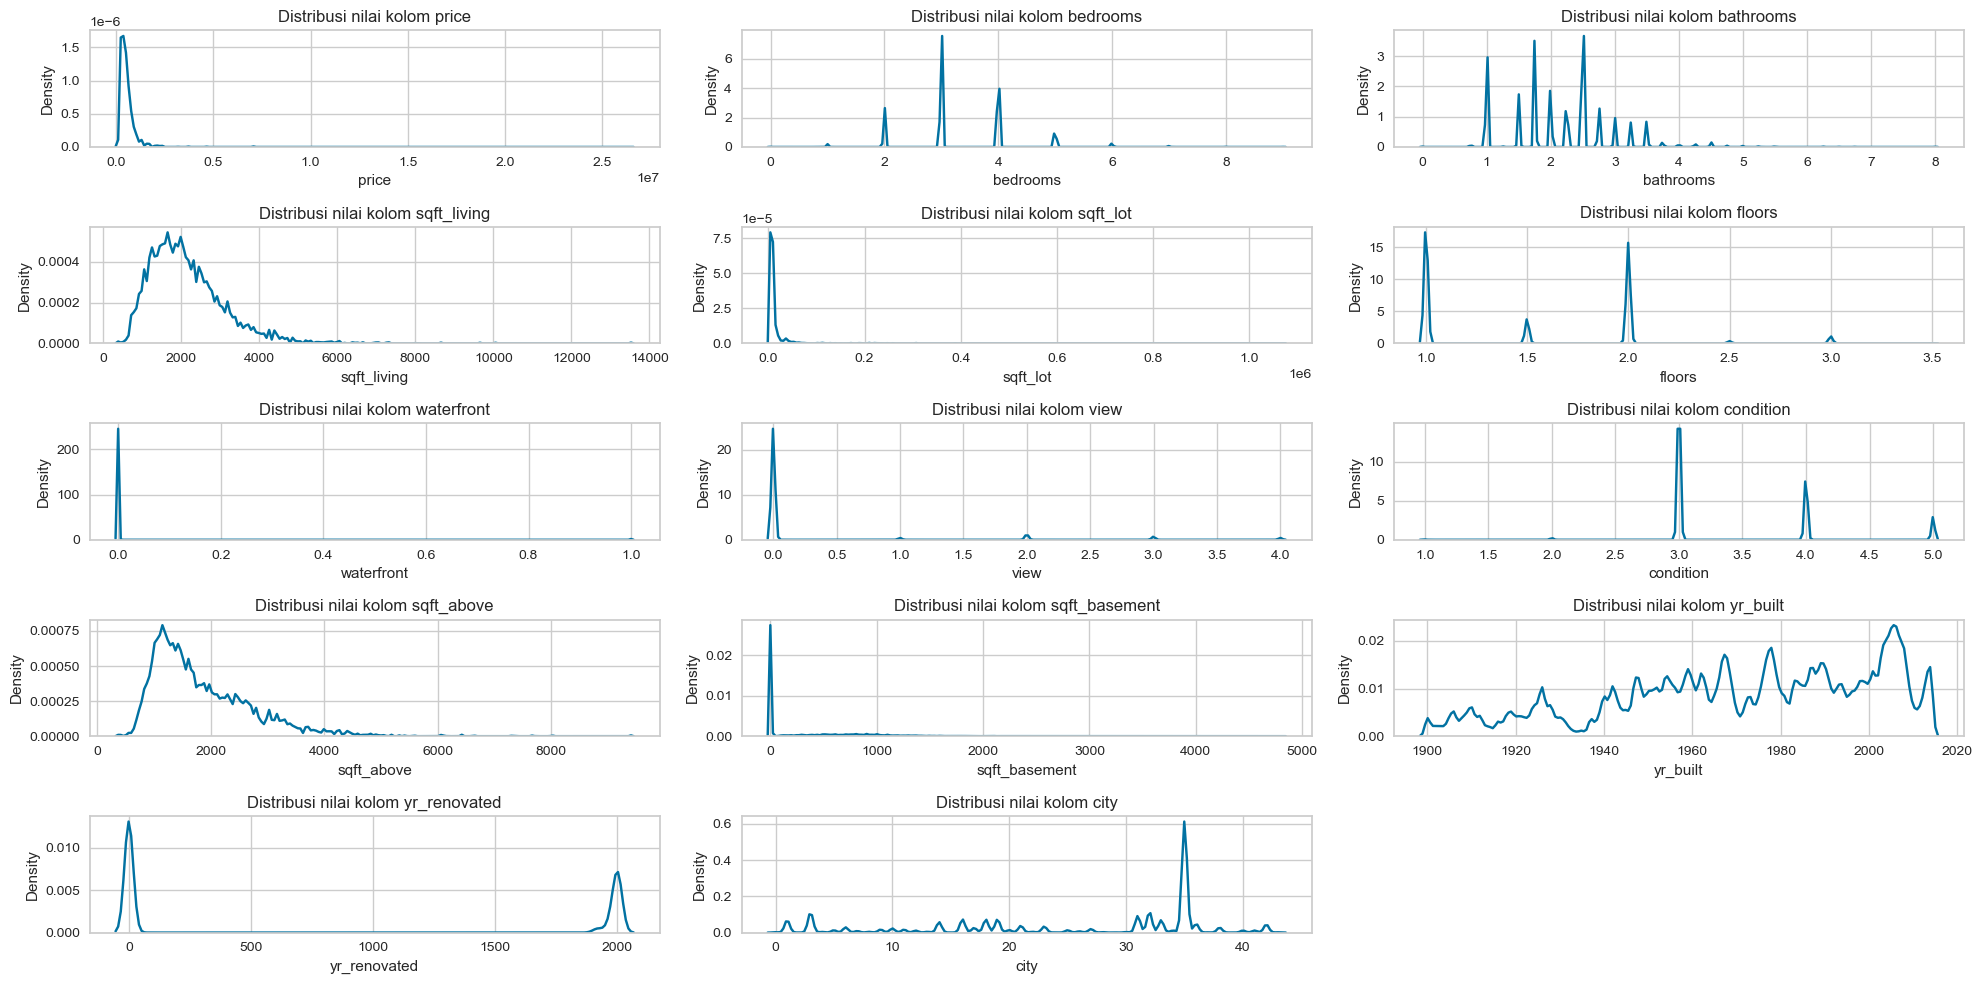

In [15]:
num_cols = 3
num_rows = math.ceil(len(numerical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))

for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.kdeplot(data = data, x = column, ax=axes[row, col], bw_adjust=.1) \
        .set_title("Distribusi nilai kolom " + column)
    

for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# num_cols = 3
# num_rows = math.ceil(len(numerical_columns) / num_cols)

# fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))

# for i, column in enumerate(numerical_columns):
#     row = i // num_cols
#     col = i % num_cols
#     sns.kdeplot(data=data, x=column, hue="Region", 
#                 fill=True, alpha=.2, palette="YlOrRd", 
#                 common_norm=False, ax=axes[row, col],
#                 warn_singular=False)\
#         .set_title(column)

# for i in range(len(numerical_columns), num_rows * num_cols):
#     row = i // num_cols
#     col = i % num_cols
#     axes[row, col].axis('off')

# plt.tight_layout()
# plt.show()

In [ ]:
sns.pairplot(data, diag_kind="kde")

In [ ]:
# plt.subplots(figsize = (20,4))
# ax = sns.countplot(data = data, x = 'cut', palette='YlOrBr')
# ax.bar_label(ax.containers[0])

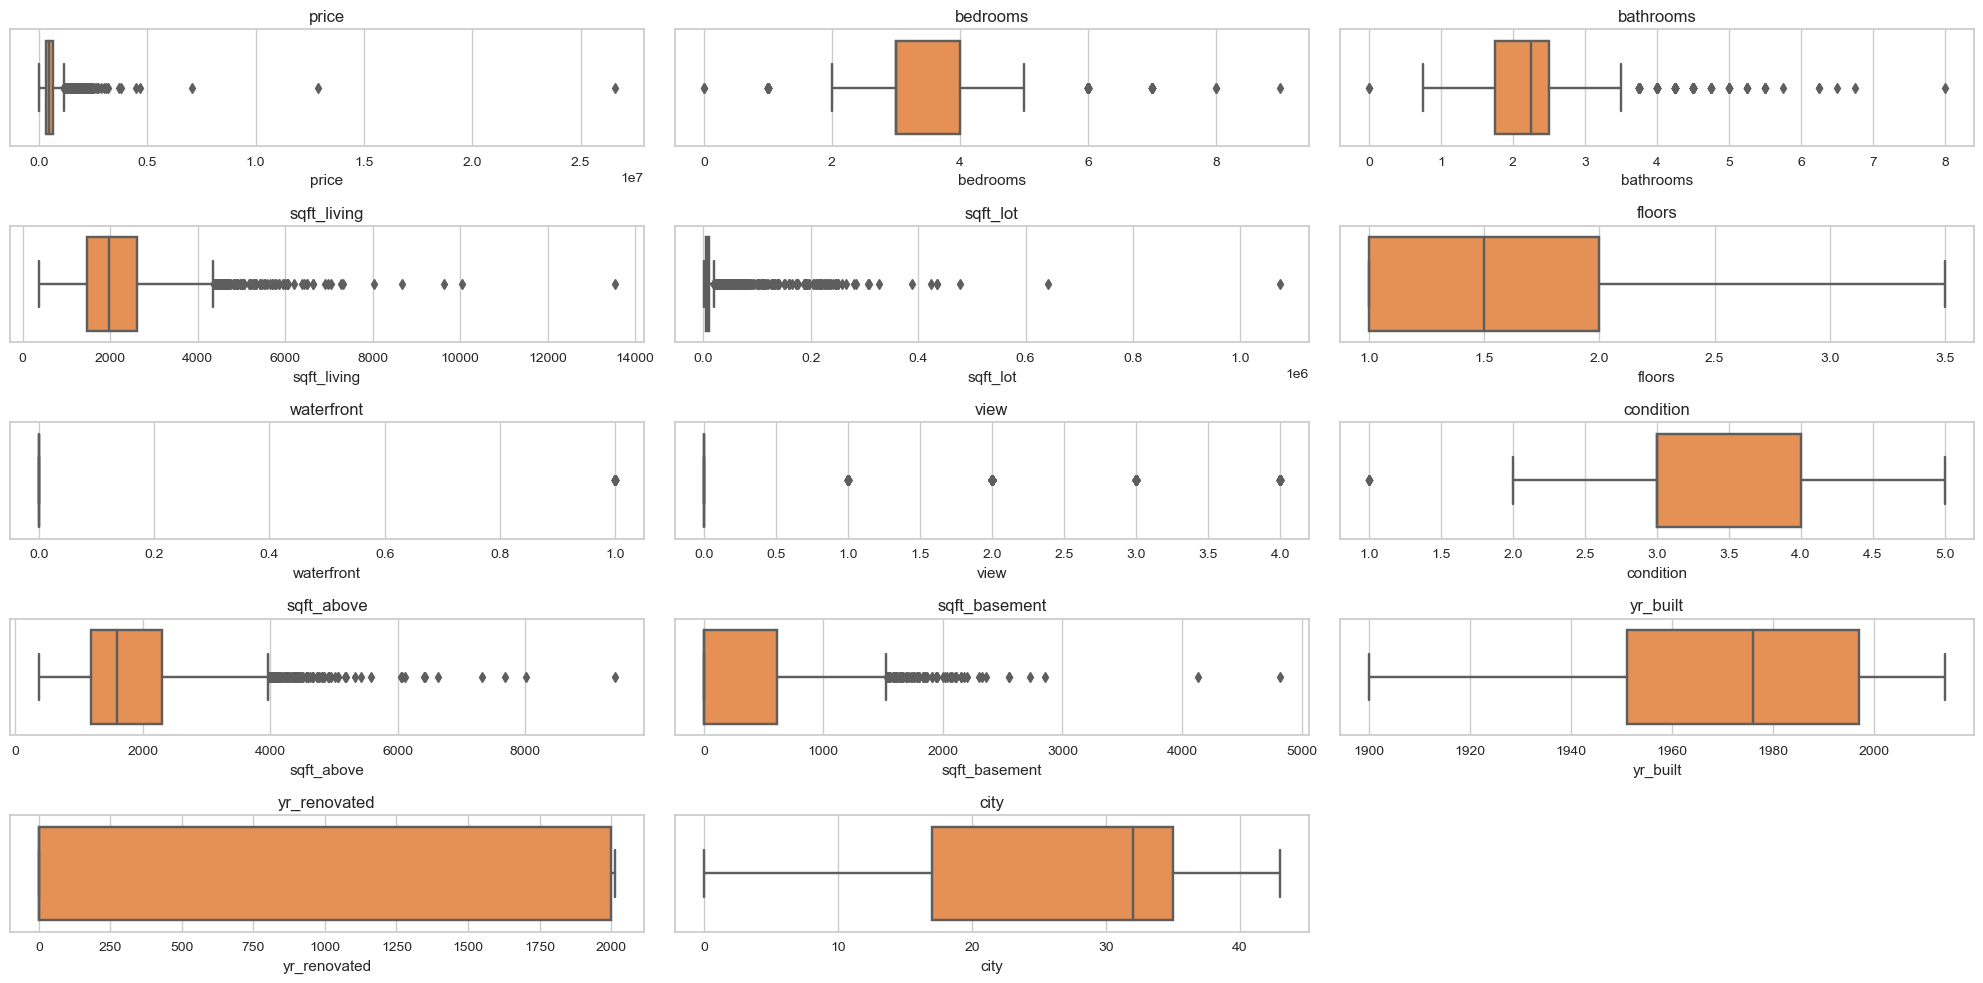

In [16]:
num_cols = 3
num_rows = math.ceil(len(numerical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))
for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.boxplot(x=data[column], ax=axes[row, col], palette="Oranges").set_title(column)
    
for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [132]:
# Q1 = data['text_len'].quantile(0.25)
# Q3 = data['text_len'].quantile(1.)

# print(Q1)
# print(Q3)

# data = data[(data['text_len'] > Q1) & (data['text_len'] < Q3)]

# fig, axes = plt.subplots(figsize=(25, 2))
# sns.boxplot(x = data['text_len'], palette="Oranges")

# sns.stripplot(x=data['text_len'], data=data,
#               size=4, color=".3", linewidth=0, palette="crest", hue=data['text_len'])

### 3.4. Data Correlation

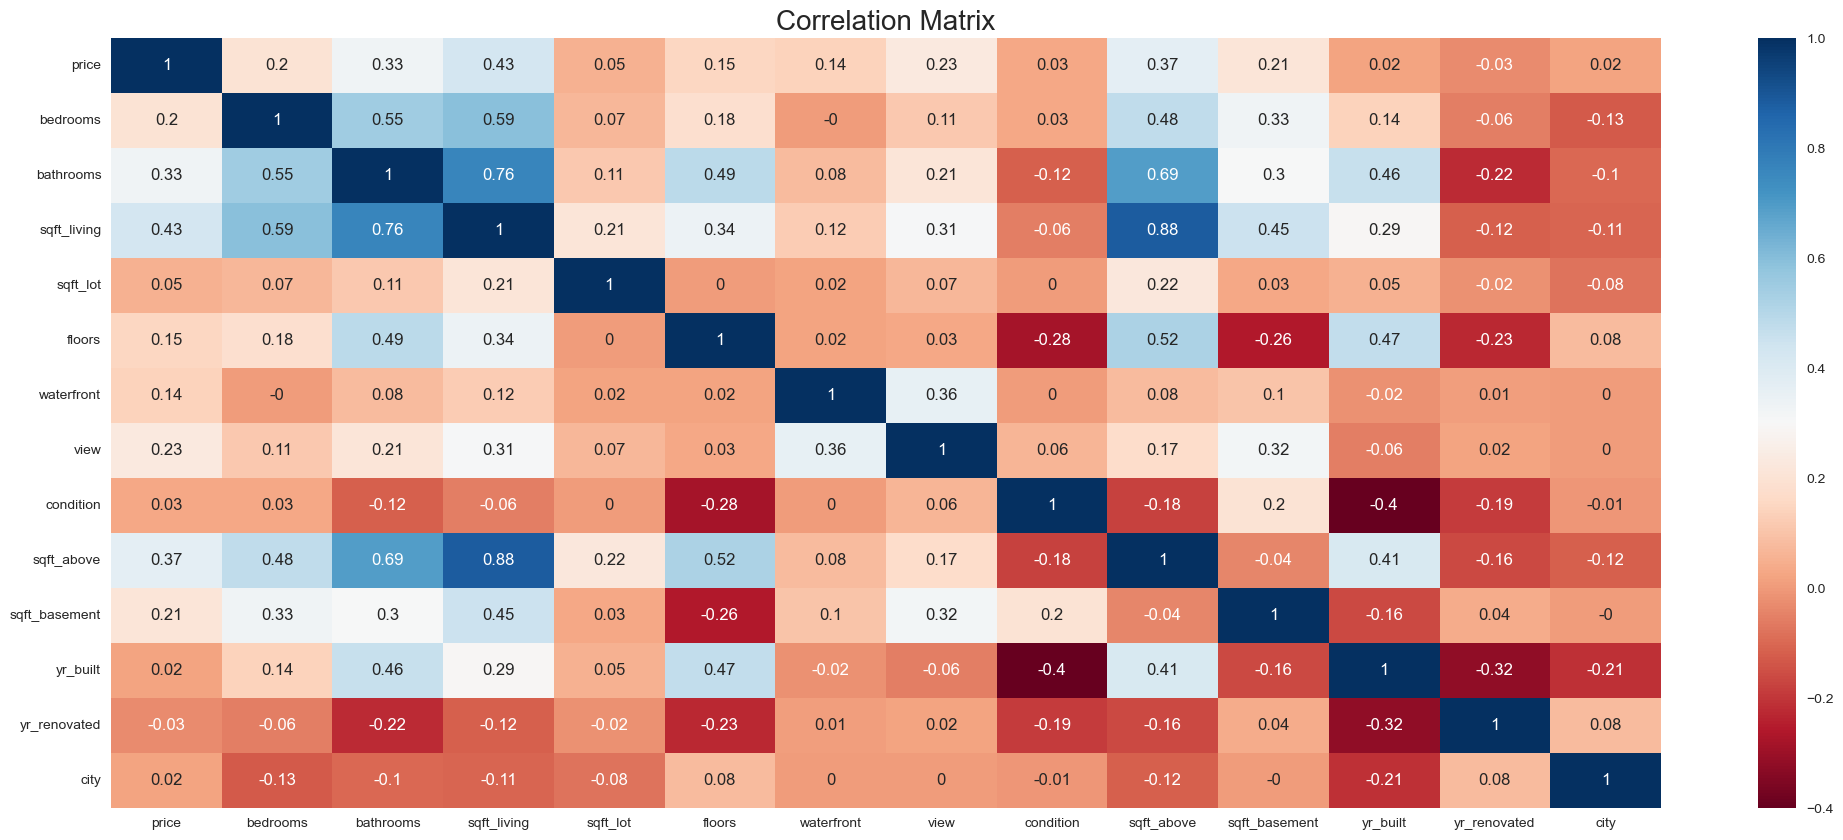

In [17]:
corr_data = data.corr().round(2)

mask = np.zeros_like(corr_data)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(25, 10))
# sns.heatmap(corr_data, annot=True, mask=mask, cmap='RdBu')
sns.heatmap(corr_data, annot=True, cmap='RdBu')
plt.title("Correlation Matrix", size=20)
plt.show()

# 4. Data Preprocessing

### 4.1. Features Selections

In [266]:
### Pearson Correlation
def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    print(str(len(cor_feature)), 'selected features')
    print(cor_feature)
    return cor_feature

### Chi-Squared
def chi_squared_elimination(X, Y,num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(X_norm, Y)
    chi_support = chi_selector.get_support()
    chi_feature = X.loc[:,chi_support].columns.tolist()
    print(str(len(chi_feature)), 'selected features')
    print(chi_feature)
    return chi_feature

### Recursive Feature Elimination
def recursive_elimination(X, Y,num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_feats, step=10, verbose=5)
    rfe_selector.fit(X_norm, Y)
    rfe_support = rfe_selector.get_support()
    rfe_feature = X.loc[:,rfe_support].columns.tolist()
    print(str(len(rfe_feature)), 'selected features')
    print(rfe_feature)
    return rfe_feature

### Lasso: SelectFromModel
def lasso_elimination(X, Y, num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"), max_features=num_feats)
    embeded_lr_selector.fit(X_norm, Y)
    embeded_lr_support = embeded_lr_selector.get_support()
    embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
    print(str(len(embeded_lr_feature)), 'selected features')
    print(embeded_lr_feature)
    return embeded_lr_feature

### LightGBM: SelectFromModel
def LGBMC_elimination(X, Y, num_feats):
    lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
                reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

    embeded_lgb_selector = SelectFromModel(lgbc, max_features=num_feats)
    embeded_lgb_selector.fit(X, Y)
    embeded_lgb_support = embeded_lgb_selector.get_support()
    embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
    print(str(len(embeded_lgb_feature)), 'selected features')
    print(embeded_lgb_feature)
    return embeded_lgb_feature

### Tree-based: SelectFromModel
def RFC_elimination (X, Y, num_feats):
    embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
    embeded_rf_selector.fit(X, Y)

    embeded_rf_support = embeded_rf_selector.get_support()
    embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
    print(str(len(embeded_rf_feature)), 'selected features')
    print(embeded_rf_feature)
    return embeded_rf_feature

In [271]:
X = data.drop(columns=['Potability'])
Y = data['Potability']

num_feats = 10

selected_feature = cor_selector(X, Y,num_feats)
# selected_feature = chi_squared_elimination(X, Y,num_feats)
# selected_feature = recursive_elimination(X, Y,num_feats)
# selected_feature = lasso_elimination(X, Y, num_feats)
# selected_feature = LGBMC_elimination(X, Y, num_feats)
# selected_feature = RFC_elimination(X, Y, num_feats)

X = data[selected_feature]
Y = data['Credit_Score']


print(Counter(Y))
undersample = RandomUnderSampler()
X, Y = undersample.fit_resample(X, Y)
print(Counter(Y))

Y = to_categorical(Y)

scaler = MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

10 selected features
['Monthly_Balance', 'Num_Bank_Accounts', 'Credit_History_Age', 'Num_Credit_Card', 'Num_of_Loan', 'Delay_from_due_date', 'Outstanding_Debt', 'Interest_Rate', 'Num_Credit_Inquiries', 'Credit_Mix']
Counter({0: 53174, 2: 28998, 1: 17828})
Counter({0: 17828, 1: 17828, 2: 17828})
(37545, 10)
(10590, 10)
(5349, 10)


### 4.2. Data Splitting

In [9]:
X = data.drop(columns=['price'])
Y = data['price']

# scaler = MinMaxScaler(feature_range=(0,1))
# scaler = RobustScaler()
# X = scaler.fit_transform(X)
scaler = PowerTransformer(method='yeo-johnson', standardize=True)
X = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(3229, 13) (3229,)
(911, 13) (911,)
(460, 13) (460,)


# 5. Neural Network Algoritms

In [21]:
def DNN_Model():
    model = Sequential()
    model.add(Dense(1024, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.01), input_shape=(X_train.shape[1],)))
    # model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.01)))
    # model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.01)))
    # model.add(Dropout(0.5))
    model.add(Dense(1))
    
    return model

def LSTM_Model():
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    # model.add(LSTM(64))
    model.add(Dense(32, activation='relu'))
    # model.add(Dropout(0.2))
    # model.add(Dropout(0.5))
    # model.add(Dense(16, activation='relu'))
    model.add(Dense(1))
    return model

def GRU_Model():
    model = Sequential()
    model.add((GRU(128, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True, input_shape = (X_train.shape[1],1))))
    # model.add(GRU(64, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True))
    model.add((GRU(128, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True)))
    # model.add(Dense(128, activation='relu'))
    # model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    return model

model = DNN_Model()
# model = LSTM_Model()
# model = GRU_Model()

model.summary()

# opt = SGD(learning_rate=0.01, momentum=0.9)
opt = Adam(learning_rate = 0.000_1)

model.compile(loss='mse', optimizer=opt, metrics=['mse'])
# model.compile(loss='mae', optimizer = opt, metrics=['mae'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1024)              14336     
                                                                 
 dense_5 (Dense)             (None, 256)               262400    
                                                                 
 dense_6 (Dense)             (None, 64)                16448     
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 293,249
Trainable params: 293,249
Non-trainable params: 0
_________________________________________________________________


In [27]:
num_epoch = 100
batch_size = 32

history = model.fit(X_train, y_train, verbose=2,
                    batch_size = batch_size, epochs = num_epoch, 
                    validation_data = (X_val, y_val))

Epoch 1/100
101/101 - 0s - loss: 104501575680.0000 - mse: 104501575680.0000 - val_loss: 53514870784.0000 - val_mse: 53514870784.0000 - 487ms/epoch - 5ms/step
Epoch 2/100
101/101 - 0s - loss: 104512528384.0000 - mse: 104512528384.0000 - val_loss: 53488513024.0000 - val_mse: 53488513024.0000 - 292ms/epoch - 3ms/step
Epoch 3/100
101/101 - 0s - loss: 104530345984.0000 - mse: 104530345984.0000 - val_loss: 53481447424.0000 - val_mse: 53481447424.0000 - 289ms/epoch - 3ms/step
Epoch 4/100
101/101 - 0s - loss: 104487583744.0000 - mse: 104487583744.0000 - val_loss: 53456871424.0000 - val_mse: 53456871424.0000 - 289ms/epoch - 3ms/step
Epoch 5/100
101/101 - 0s - loss: 104465465344.0000 - mse: 104465465344.0000 - val_loss: 53446082560.0000 - val_mse: 53446082560.0000 - 282ms/epoch - 3ms/step
Epoch 6/100
101/101 - 0s - loss: 104481636352.0000 - mse: 104481636352.0000 - val_loss: 53431308288.0000 - val_mse: 53431308288.0000 - 271ms/epoch - 3ms/step
Epoch 7/100
101/101 - 0s - loss: 104462073856.0000 -

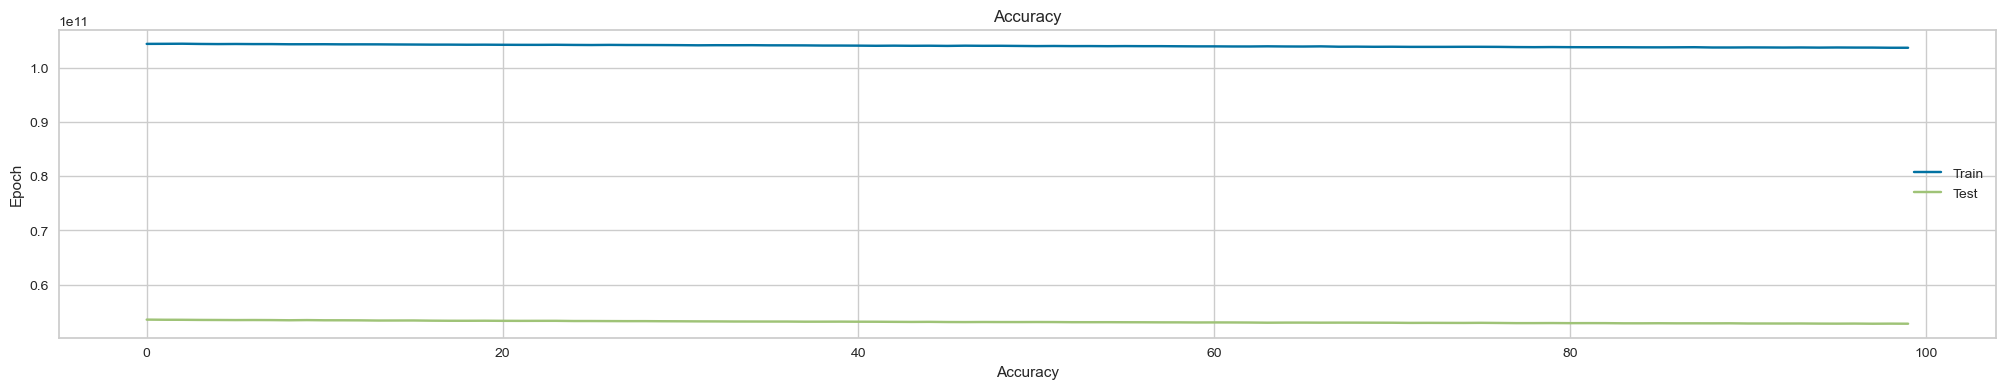

In [28]:
fig, ax = plt.subplots(figsize=(25, 4))
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('Accuracy')
ax.set_xlabel('Accuracy')
ax.set_ylabel('Epoch')

plt.legend(['Train', 'Test'])
plt.show()

In [29]:
y_pred = model.predict(X_test, verbose = 0)

print("R Squared Error    :",round(r2_score(y_test, y_pred), 2))
print("Mean Squared Error :",round(mean_squared_error(y_test, y_pred), 2))
print("Mean Absolute Error:",round(mean_absolute_error(y_test, y_pred), 2))

R Squared Error    : 0.09
Mean Squared Error : 863318640036.79
Mean Absolute Error: 191552.16


In [30]:
train_predictions = model.predict(X_test, verbose=0).flatten()

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_test})
train_results['Diff'] = abs(train_results['Actuals'] - train_results['Train Predictions'])
print(train_results.head(5))
print((train_results['Diff'].mean()), '/', (train_results['Diff'].sum()))
print((train_results['Diff'].max()))


      Train Predictions    Actuals          Diff
2966       3.078100e+05   250000.0   57809.96875
1660       1.095603e+06  1505000.0  409397.25000
1078       8.351222e+05   542500.0  292622.18750
3509       6.226336e+05   370000.0  252633.62500
3032       5.590868e+05   374000.0  185086.75000
191552.15735687266 / 174504015.35211098
26361698.046875


In [33]:
data_x = data.drop(columns=['price'])

scaler = RobustScaler()
data_x = scaler.fit_transform(data_x)
scaler = PowerTransformer(method='yeo-johnson', standardize=True)
data_x = scaler.fit_transform(data_x)

predictions = (model.predict(data_x, verbose=0)).astype(int).flatten()

data['Overall Prediction'] = pd.DataFrame(predictions)
data

InvalidArgumentError: Graph execution error:

Detected at node 'sequential_1/dense_4/MatMul' defined at (most recent call last):
    File "c:\Users\indiz\miniconda3\envs\gan\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\indiz\miniconda3\envs\gan\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\indiz\miniconda3\envs\gan\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\indiz\miniconda3\envs\gan\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\indiz\miniconda3\envs\gan\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\IPython\core\interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\IPython\core\interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\IPython\core\interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\IPython\core\interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\indiz\AppData\Local\Temp\ipykernel_15936\2127669433.py", line 8, in <module>
      predictions = (model.predict(data_x, verbose=0)).astype(int).flatten()
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\keras\engine\training.py", line 2253, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\keras\engine\training.py", line 2041, in predict_function
      return step_function(self, iterator)
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\keras\engine\training.py", line 2027, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\keras\engine\training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
      return self(x, training=False)
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\keras\layers\core\dense.py", line 241, in call
      outputs = tf.matmul(a=inputs, b=self.kernel)
Node: 'sequential_1/dense_4/MatMul'
Matrix size-incompatible: In[0]: [32,14], In[1]: [13,1024]
	 [[{{node sequential_1/dense_4/MatMul}}]] [Op:__inference_predict_function_151631]

# 6. Supervised Learning

### 6.1. Stacking Algoritms

In [6]:
import optuna

def objective(trial, data = data):
    
    X = data.drop(columns=['price'])
    Y = data['price']

    scaler = RobustScaler()
    X = scaler.fit_transform(X)
    scaler = PowerTransformer(method='yeo-johnson', standardize=True)
    X = scaler.fit_transform(X)

    X_train,X_test,y_train,y_test = train_test_split(data, Y, test_size=0.25, random_state=42)
    
    param = {
        'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process
        'lambda': trial.suggest_loguniform('lambda', 1e-4, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-4, 1.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators': trial.suggest_categorical('n_estimators', [1000,2000,3000,4000]),
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17,20]),
        'random_state': trial.suggest_categorical('random_state', [24, 48,2020]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    model = XGBRegressor(**param)  
    
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=False)
    preds_valid = model.predict(X_test)
    rmse = mean_squared_error(y_test, preds_valid, squared=False)
    return rmse

    
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

study.best_params

[I 2023-05-04 18:46:33,336] A new study created in memory with name: no-name-e794fba7-d5b7-442a-959e-2df01eca1f4b
[I 2023-05-04 18:46:36,950] Trial 0 finished with value: 856327.0952753084 and parameters: {'lambda': 0.030313705285718258, 'alpha': 0.09223660822507028, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.01, 'n_estimators': 3000, 'max_depth': 11, 'random_state': 24, 'min_child_weight': 226}. Best is trial 0 with value: 856327.0952753084.
[I 2023-05-04 18:46:39,664] Trial 1 finished with value: 855551.5551969948 and parameters: {'lambda': 0.002819844744025012, 'alpha': 6.9828382764920445, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.014, 'n_estimators': 4000, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 251}. Best is trial 1 with value: 855551.5551969948.
[I 2023-05-04 18:46:41,808] Trial 2 finished with value: 854983.6857566872 and parameters: {'lambda': 0.024309796988780347, 'alpha': 0.048551384984530155, 'colsample_bytree': 0.9, 's

{'lambda': 0.5586512775469143,
 'alpha': 2.627433971295785,
 'colsample_bytree': 0.9,
 'subsample': 1.0,
 'learning_rate': 0.014,
 'n_estimators': 3000,
 'max_depth': 13,
 'random_state': 24,
 'min_child_weight': 1}

In [26]:
best_params = {'lambda': 0.5586512775469143,
'alpha': 2.627433971295785,
'colsample_bytree': 0.9,
'subsample': 1.0,
'learning_rate': 0.014,
'n_estimators': 3000,
'max_depth': 13,
'random_state': 24,
'min_child_weight': 1}

adaboost = AdaBoostRegressor(n_estimators = 100, random_state = 42)
bagging = BaggingRegressor(n_jobs = -1)
extraTrees = ExtraTreesRegressor(max_depth = 100, n_jobs = -1, random_state = 42)
gradient = GradientBoostingRegressor(max_depth = 100, n_estimators = 100, learning_rate = .01,  random_state = 0)
randomForest = RandomForestRegressor(max_depth = 100, random_state = 42, n_jobs = -1)
histGradient = HistGradientBoostingRegressor()
XGB = XGBRegressor(**best_params)
knn = KNeighborsRegressor(n_jobs = -1)
decisionTree = DecisionTreeRegressor( max_depth = 100, random_state = 42)
linear = LinearRegression()

model = StackingRegressor([
    # ('extraTrees', extraTrees),
    # ('histGradient', histGradient),
    # ('adaboost', adaboost),
    # ('bagging', bagging),
    # ('randomforest', randomForest),
    ('XGB', XGB),
    # ('decisionTree', decisionTree),
    # ('linear', linear),
    # ('gradient', gradient),
    # ('knn', knn),
], n_jobs=-1)

In [27]:
model.fit(X_train, y_train)

XGBRegressor(alpha=2.627433971295785, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=0.5586512775469143,
             learning_rate=0.014, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=13,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, n_estimators=3000, n_jobs=None,
             num_parallel_tree=None, ...)

In [28]:
print("Train Score        :",round((model.score(X_train, y_train)*100), 2),'%')
print("Test Score         :",round((model.score(X_test, y_test)*100), 2),'%')
print("Validationg Score  :",round((model.score(X_val, y_val)*100), 2),'%')

y_pred = model.predict(X_test)

print("R Squared Error    :",round(r2_score(y_test, y_pred), 2))
print("Mean Squared Error :",round(mean_squared_error(y_test, y_pred), 2))
print("Mean Absolute Error:",round(mean_absolute_error(y_test, y_pred), 2))

Train Score        : 100.0 %
Test Score         : 7.02 %
Validationg Score  : 44.62 %
R Squared Error    : 0.07
Mean Squared Error : 877813410728.28
Mean Absolute Error: 174433.75


In [25]:
train_predictions = (model.predict(X_test)).astype(int).flatten()

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_test.astype(int)})
train_results['Diff'] = abs(train_results['Actuals'] - train_results['Train Predictions'])
print(train_results.head(5))
print((train_results['Diff'].mean()), '/', (train_results['Diff'].sum()))
print((train_results['Diff'].max()))


      Train Predictions  Actuals    Diff
2966             246166   250000    3834
1660             883390  1505000  621610
1078             628909   542500   86409
3509             482480   370000  112480
3032             499492   374000  125492
179699.74423710207 / 163706467
26273907


In [60]:
data_x = data.drop(columns=['Name', 'Overall'])

scaler = RobustScaler()
data_x = scaler.fit_transform(data_x)
scaler = PowerTransformer(method='yeo-johnson', standardize=True)
data_x = scaler.fit_transform(data_x)

predictions = np.rint(model.predict(data_x)).astype(int).flatten()

data['Overall Prediction'] = pd.DataFrame(predictions)
data

,Name,Age,Nationality,Overall,Potential,Club,Preferred Foot,International Reputation,Weak Foot,Skill Moves,...,GKReflexes,Defending,General,Mental,Passing,Mobility,Power,Shooting,Rating,Overall Prediction
0,L. Messi,31,6,94,94,212,0,5.0,4.0,4.0,...,8.0,29,89,71,87,91,74,88,94,94
1,Cristiano Ronaldo,33,123,94,94,326,1,5.0,4.0,5.0,...,11.0,27,88,73,81,91,83,88,94,94
2,Neymar Jr,26,20,92,93,436,1,5.0,5.0,5.0,...,11.0,28,85,72,80,94,69,84,92,92
3,De Gea,27,139,91,93,375,1,4.0,3.0,1.0,...,94.0,16,26,43,39,66,54,21,92,89
4,K. De Bruyne,27,13,91,92,374,1,4.0,5.0,4.0,...,13.0,59,79,81,92,81,76,85,92,91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18202,J. Lundstram,19,46,47,65,165,1,1.0,2.0,2.0,...,9.0,45,39,46,43,55,54,37,56,47
18203,N. Christoffersson,19,144,47,63,588,1,1.0,2.0,2.0,...,12.0,19,41,37,30,40,52,39,55,47
18204,B. Worman,16,46,47,67,122,1,1.0,3.0,2.0,...,13.0,19,43,36,30,59,51,42,57,47
18205,D. Walker-Rice,17,46,47,66,587,1,1.0,3.0,2.0,...,9.0,24,44,38,39,48,50,45,56,48


### 6.2. Pycarets

In [37]:
s = RegressionExperiment()
s.setup(data, target = 'Item_Outlet_Sales', session_id = 123)

,Description,Value
0,Session id,123
1,Target,Item_Outlet_Sales
2,Target type,Regression
3,Original data shape,"(1705, 37)"
4,Transformed data shape,"(1705, 37)"
5,Transformed train set shape,"(1193, 37)"
6,Transformed test set shape,"(512, 37)"
7,Numeric features,36
8,Preprocess,True
9,Imputation type,simple


In [38]:
best = s.compare_models()
print(best)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,17:30:58
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


HuberRegressor()


In [ ]:
s.evaluate_model(best)

In [39]:
s.predict_model(best)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,590.1542,797415.2204,892.9811,0.7127,0.4866,0.4199


,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_LF,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Fat_Content_low fat,Item_Fat_Content_reg,Item_Type_Baking Goods,...,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Overall Prediction,Item_Outlet_Sales,prediction_label
1134,12.150000,0.021757,165.018402,1999,0,1,0,0,0,0,...,1,0,0,0,1,0,0,2658,3302.367920,2684.177348
249,9.800000,0.141406,50.000801,2007,0,0,1,0,0,1,...,0,1,0,0,1,0,0,1643,506.007996,1572.491272
1143,6.135000,0.079327,152.836594,1997,0,0,1,0,0,1,...,1,0,0,0,1,0,0,2648,2871.595459,2468.206772
809,12.911574,0.124300,73.469597,1985,0,1,0,0,0,0,...,1,0,0,1,0,0,0,313,298.278412,381.094023
657,6.920000,0.038447,63.585201,2004,0,1,0,0,0,0,...,0,1,0,0,1,0,0,883,751.022400,950.244089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,17.200001,0.025162,145.941803,2004,0,0,1,0,0,0,...,0,1,0,0,1,0,0,2694,1765.701660,2689.931096
1688,9.800000,0.026895,128.401993,2002,0,1,0,0,0,0,...,0,1,0,0,1,0,0,1637,2403.538086,1719.376834
1612,16.000000,0.173463,157.697205,2009,0,0,1,0,0,0,...,0,0,1,0,0,1,0,2359,2960.146729,2184.149560
954,9.800000,0.013830,45.306000,1987,0,1,0,0,0,0,...,0,0,1,0,1,0,0,1388,1304.968018,1318.843237
